# Pneumonia Detection using CNN

## What is Pneumonia?

#### Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli. The alveoli fill with fluid or pus, making it difficult to breathe.

#### It can be caused mainly due to infection by Viruses and Bacteria and less commonly by other micro-organisms, certain medications or conditions such as autoimmune diseases.

<p>Each year, pneumonia affects about 450 million people globally (7% of the population) and results in about 4 million deaths. With the introduction of antibiotics and vaccines in the 20th century, survival has greatly improved.</p>
<p>Nevertheless, in developing countries, and also among the very old, the very young and the chronically ill, pneumonia remains a leading cause of death.</p> 
<p>Pneumonia often shortens the period of suffering among those already close to death and has thus been called "the old man's friend".</p>

<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRsC1mtsZeZ-f0Ipq9dX145SKxD8fLiGkdAYw&usqp=CAU'>

### In this notebook, we will be looking at the X-ray images of lungs and based on the training and validation images, we will train our CNN model to classify the test x-ray images of lungs as "NORMAL" or "PNEUMONIA".

#### Step 1: Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
%matplotlib inline

#### Step 2: Set random seed to a fixed value to replicate the results of random shuffling.

In [2]:
np.random.seed(0)

#### Step 3: Import the Train, Validation and Test datasets and shuffle the datasets within to make sure the trained model is not biased.

In [3]:
data_dir = Path('../DataSets/PneumoniaDataSet/chest_xray')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [4]:
N_cases_train_dir = train_dir / 'NORMAL'
P_cases_train_dir = train_dir / 'PNEUMONIA'

N_cases_train = N_cases_train_dir.glob('*.jpeg')
P_cases_train = P_cases_train_dir.glob('*.jpeg')

N_cases_test_dir = test_dir / 'NORMAL'
P_cases_test_dir = test_dir / 'PNEUMONIA'

N_cases_test = N_cases_test_dir.glob('*.jpeg')
P_cases_test = P_cases_test_dir.glob('*.jpeg')

N_cases_val_dir = val_dir / 'NORMAL'
P_cases_val_dir = val_dir / 'PNEUMONIA'

N_cases_val = N_cases_val_dir.glob('*.jpeg')
P_cases_val = P_cases_val_dir.glob('*.jpeg')

In [5]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    print(data_dir)
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    data = np.array(data)
    np.random.shuffle(data)
    return data

In [6]:
train = get_data(train_dir)
test = get_data(test_dir)
val = get_data(val_dir)

..\DataSets\PneumoniaDataSet\chest_xray\train
..\DataSets\PneumoniaDataSet\chest_xray\test
..\DataSets\PneumoniaDataSet\chest_xray\val


#### Step 4: Exploratory Data Analysis

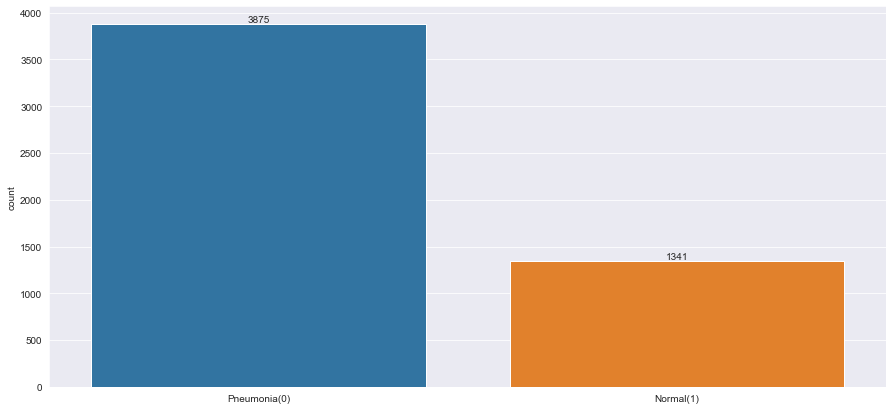

In [7]:
label_count_plot = []
for i in train:
    if(i[1] == 0):
        label_count_plot.append("Pneumonia(0)")
    else:
        label_count_plot.append("Normal(1)")
plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
c_plot = sns.countplot(label_count_plot)
for p in c_plot.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    c_plot.annotate('{}'.format(int(y)), (x.mean(), y), 
            ha='center', va='bottom')

Text(0.5, 1.0, 'PNEUMONIA')

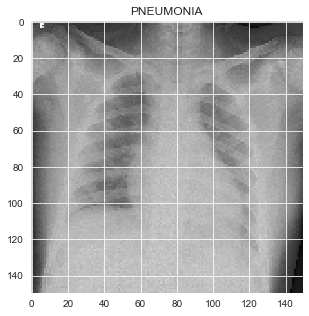

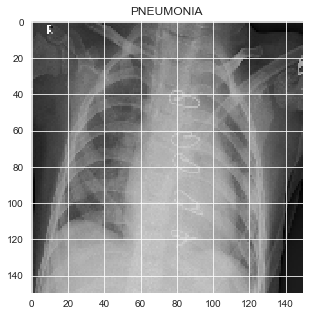

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

#### Step 5: ETL method to prepare data for training the model

In [9]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [10]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [11]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [12]:
dataGenerator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


dataGenerator.fit(x_train)

#### Step 6: Model Building

##### Model and Layers definition
<p />
Conv2D Arguments:
<p />
1. strides: The amount of movement between applications of the filter to the input image is referred to as the stride, and it is almost always symmetrical in height and width dimensions.
<p />
2. padding: In Keras, this is specified via the “padding” argument on the Conv2D layer, which has the default value of 'valid' (no padding). This means that the filter is applied only to valid ways to the input.
   The 'padding' value of 'same' calculates and adds the padding required to the input image (or feature map) to ensure that the output has the same shape as the input.
<p />
3. activation: The activation parameter to the Conv2D class is simply a convenience parameter which allows you to supply a string, which specifies the name of the activation function you want to apply after performing the convolution.

In [13]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

##### Adding callback functions to perform at each epoch

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)

##### Training the Model on training data along with validation data to validate the model

In [15]:
history = model.fit(dataGenerator.flow(x_train,y_train, batch_size = 32) ,epochs = 12, validation_data = dataGenerator.flow(x_val, y_val) ,callbacks = [learning_rate_reduction, checkpoint])

Epoch 1/12
163/163 [==============================] - ETA: 0s - loss: 0.5269 - accuracy: 0.8432
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5
163/163 [==============================] - 11s 69ms/step - loss: 0.5269 - accuracy: 0.8432 - val_loss: 30.5879 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - ETA: 0s - loss: 0.2893 - accuracy: 0.8919
Epoch 00002: val_accuracy did not improve from 0.50000
163/163 [==============================] - 11s 69ms/step - loss: 0.2893 - accuracy: 0.8919 - val_loss: 62.6431 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.9114
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 00003: val_accuracy did not improve from 0.50000
163/163 [==============================] - 11s 70ms/step - loss: 0.2439 - accuracy: 0.9114 - val_loss: 24.9825 - val_accuracy: 0.5000 - lr: 

#### Step 7: Predictions

##### Calling in the best model saved (based on validation accuracy) and getting its performance on Test data.

In [16]:
model = load_model('best_model.h5')

print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 9ms/step - loss: 0.3177 - accuracy: 0.8670
Loss of the model is -  0.3177158534526825
20/20 [==============================] - 0s 9ms/step - loss: 0.3177 - accuracy: 0.8670
Accuracy of the model is -  86.69871687889099 %


##### Plotting the Training and Validation Accuracy and Losses

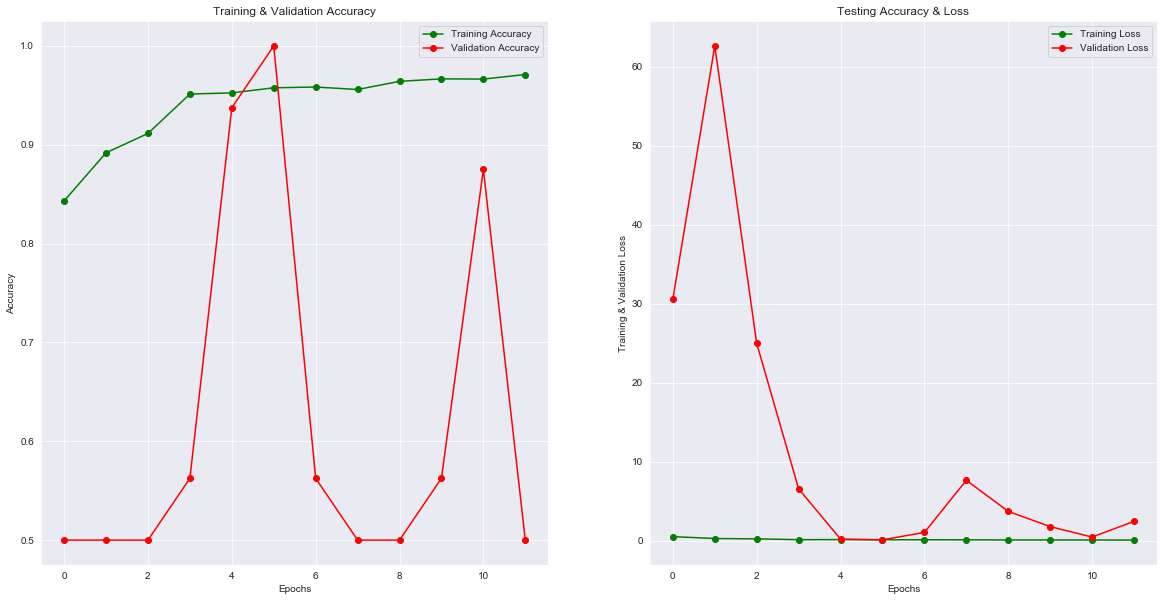

In [17]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

#### Step 8: Plotting model Performance

Since we cannot really judge the model based on accuracy because, if the test set has 20 images out of which 18 are of NORMAL category and 2 of PNEUMONIA category, and if the model predicts all of them as normal, we will be getting a 90% accuracy but in reality, its not really a good model. So, we plot a Confusion Matrix to get to know the actual numbers of correct and incorrect predictions and calculate the Precision and Recall values for better evaluation of the model.

Precision = True Positive / (True Positive + False Positive)

Recall = True Positive / (True Positive + False Negetive)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.85      0.89       390
   Normal (Class 1)       0.78      0.90      0.84       234

           accuracy                           0.87       624
          macro avg       0.86      0.87      0.86       624
       weighted avg       0.88      0.87      0.87       624

Recall of the model is 0.90
Precision of the model is 0.78


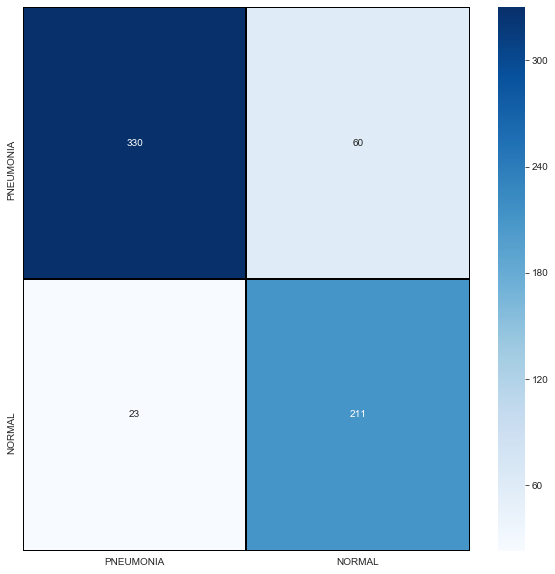

In [18]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

cm = confusion_matrix(y_test,predictions)
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

#### Step 9: Outputs

In [19]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

Some Correct predictions where out model did well!

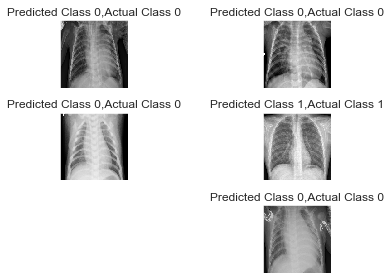

In [20]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

Some incorrect predictions which suggest our model needs some improvement for better classification.

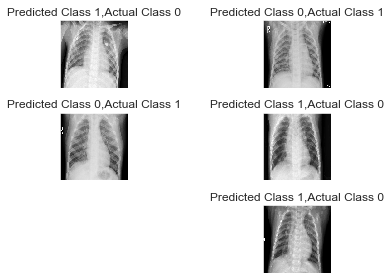

In [21]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1